# Overview
The Dirty Cafe Sales dataset contains 10,000 rows across 8 columns of synthetic data representing sales transactions in a cafe. This dataset is intentionally "dirty," with missing values, inconsistent data, and errors introduced to provide a realistic scenario for data cleaning and exploratory data analysis (EDA). It can be used to practice cleaning techniques, data wrangling, and feature engineering.

We aim to handle all missing values and detect outliers to ensure the data is clean and suitable for model training.

In [1]:
# import the libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='white')
np.random.seed(0)

In [2]:
# load the data
df = pd.read_csv('/kaggle/input/cafe-sales-dirty-data-for-cleaning-training/dirty_cafe_sales.csv')
df.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


# EDA

In [3]:
# check the data types of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   object
 3   Price Per Unit    9821 non-null   object
 4   Total Spent       9827 non-null   object
 5   Payment Method    7421 non-null   object
 6   Location          6735 non-null   object
 7   Transaction Date  9841 non-null   object
dtypes: object(8)
memory usage: 625.1+ KB


In [4]:
# get an overview of the descriptives
df.describe()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
count,10000,9667,9862,9821,9827,7421,6735,9841
unique,10000,10,7,8,19,5,4,367
top,TXN_1961373,Juice,5,3.0,6.0,Digital Wallet,Takeaway,UNKNOWN
freq,1,1171,2013,2429,979,2291,3022,159


In [5]:
# check for missing values
df.isnull().sum()

Transaction ID         0
Item                 333
Quantity             138
Price Per Unit       179
Total Spent          173
Payment Method      2579
Location            3265
Transaction Date     159
dtype: int64

In [6]:
# check for duplicates
df.duplicated().sum()

0

# Preprocessing
### Handling missing values

In [7]:
# make a copy of the dataframe
df1 = df.copy()

In [8]:
# replace "ERROR" and "UNKNOWN" with NaN for easier handling later on
df1 = df1.replace(["ERROR", "UNKNOWN"], np.nan, regex=True)

In [9]:
# assign new data types to the different columns

# convert to numeric
df1[['Price Per Unit', 'Quantity', 'Total Spent']] = df1[['Price Per Unit', 'Quantity', 'Total Spent']].apply(pd.to_numeric, errors='coerce')

# convert to category
df1[['Item', 'Location', 'Payment Method']] = df1[['Item', 'Location', 'Payment Method']].astype('category')

# convert to datetime
df1['Transaction Date'] = pd.to_datetime(df1['Transaction Date'], errors='coerce')

In [10]:
# check what percentage of the data is missing
total_null = df1.isnull().sum().sum()
total_cells = np.prod(df1.shape)
percentage_null = (total_null / total_cells) * 100
percentage_null

12.6025

We'll use the dataset-provided menu to assign the known **Price Per Unit** to its corresponding **Item** where missing.

In [11]:
# create a dictionary with the known menu prices
menu = {
    "Coffee": 2,
    "Tea": 1.5,
    "Sandwich": 4,
    "Salad": 5,
    "Cake": 3,
    "Cookie": 1,
    "Smoothie": 4,
    "Juice": 3
}

# fill the missing Price Per Unit values where Item is not null
df1['Price Per Unit'] = df1['Price Per Unit'].fillna(df1['Item'].map(menu))

Now, we'll reverse the mapping, using **Price Per Unit** as the key and **Item** names as the values.

In [12]:
# create an items dictionary that maps the menu prices in reverse
items = {
    2: "Coffee",
    1.5: "Tea",
    4 : "Sandwich",
    5 : "Salad",
    3 : "Cake",
    1 : "Cookie",
    4 : "Smoothie",
    3 : "Juice"
}

# fill the missing Item where Price Per Unit is not null
df1['Item'] = df1['Item'].fillna(df1['Price Per Unit'].map(items))

The columns **Price Per Unit**, **Quantity**, and **Total Spent** are mathematically related:

Total Spent = Price Per Unit × Quantity

Price Per Unit = Total Spent ÷ Quantity

Quantity = Total Spent ÷ Price Per Unit

We'll create a function to fill missing values by leveraging these relationships, provided two of the three values are available in a given row.

In [13]:
# create a function to fill missing values in the numeric columns
def fill_NaN(df1):
    # fill missing values in Total Spent by Price Per Unit * Quantity
    condition = df1['Price Per Unit'].notnull() & df1['Quantity'].notnull()
    df1.loc[condition, 'Total Spent'] = df1.loc[condition, 'Price Per Unit'] * df1.loc[condition, 'Quantity']

    #fill missing values in Quantity by Total Spent / Price Per Unit
    condition = df1['Total Spent'].notnull() & df1['Quantity'].notnull()
    df1.loc[condition, 'Price Per Unit'] = df1.loc[condition, 'Total Spent'] / df1.loc[condition, 'Quantity']

    #fill missing values in Price Per Unit by Total Spent / Quantity
    condition = df1['Total Spent'].notnull() & df1['Price Per Unit'].notnull()
    df1.loc[condition, 'Quantity'] = df1.loc[condition, 'Total Spent'] / df1.loc[condition, 'Price Per Unit']

    return df1

df1 = fill_NaN(df1)

In [14]:
# fill the remaining missing values in Item by the mode
df1['Item'] = df1['Item'].fillna(df1['Item'].mode()[0])

# fill the remaining missing values Price Per Unit with the known Item prices
df1['Price Per Unit'] = df1['Price Per Unit'].fillna(df1['Item'].map(menu))

In [15]:
# fill the re missing values in Quantity by the mean quantity of each Item
df1['Quantity'] = df1['Quantity'].fillna(df1.groupby('Item', observed=False)['Quantity'].transform('mean'))

In [16]:
# run the function again to fill the missing values in Total Spent
df1 = fill_NaN(df1)

In [17]:
# check that all missing values in Item, Quantity, Price Per Unit, and Total Spent have been handled
df1.isnull().sum()

Transaction ID         0
Item                   0
Quantity               0
Price Per Unit         0
Total Spent            0
Payment Method      3178
Location            3961
Transaction Date     460
dtype: int64

The **Payment Method** and **Location** columns do not appear to show a significant correlation with the other columns (code not shown here).

Both columns seem to be fairly balanced (see below), so when imputing their missing values, we will aim to preserve this balance.

In [18]:
# check the value counts in Payment Method
df1['Payment Method'].value_counts()

Payment Method
Digital Wallet    2291
Credit Card       2273
Cash              2258
Name: count, dtype: int64

In [19]:
# check the value counts in Location
df1['Location'].value_counts()

Location
Takeaway    3022
In-store    3017
Name: count, dtype: int64

In [20]:
# calculate the distribution of 'Payment Method'
payment_proportions = df1['Payment Method'].value_counts(normalize=True)

# assign missing values based on the distribution
df1.loc[df1['Payment Method'].isna(), 'Payment Method'] = np.random.choice(
    payment_proportions.index, 
    size=df1['Payment Method'].isna().sum(), 
    p=payment_proportions.values
)

In [21]:
# calculate the distribution of 'Location'
location_proportions = df1['Location'].value_counts(normalize=True)

# assign missing values based on the distribution
df1.loc[df1['Location'].isna(), 'Location'] = np.random.choice(
    location_proportions.index, 
    size=df1['Location'].isna().sum(), 
    p=location_proportions.values
)

In [22]:
# check that all missing values in Payment Method and Location have been handled
df1.isnull().sum()

Transaction ID        0
Item                  0
Quantity              0
Price Per Unit        0
Total Spent           0
Payment Method        0
Location              0
Transaction Date    460
dtype: int64

There are several ways we could handle the missing values in the **Transaction Date** column. One approach would be to examine the distribution of dates and randomly impute missing values based on this distribution, similar to how we handled the **Payment Method** and **Location** columns.

However, for simplicity, we will impute the missing values using the most recent valid date, applying forward fill.

In [23]:
# fill the missing values in 'Transaction Date' with ffill
df1['Transaction Date'] = df1['Transaction Date'].ffill()

In [24]:
# final check of missing values
df1.isnull().sum()

Transaction ID      0
Item                0
Quantity            0
Price Per Unit      0
Total Spent         0
Payment Method      0
Location            0
Transaction Date    0
dtype: int64

We have now addressed all missing values in the dataset. First, we used the available known information, such as the menu prices provided in the dataset. Next, we imputed missing values based on the mathematical relationships between several columns. Finally, we imputed the missing values by preserving the distribution of the non-null values to maintain the balance of other columns.

### Outliers

First, we will graph the numeric columns to visually detect outliers.

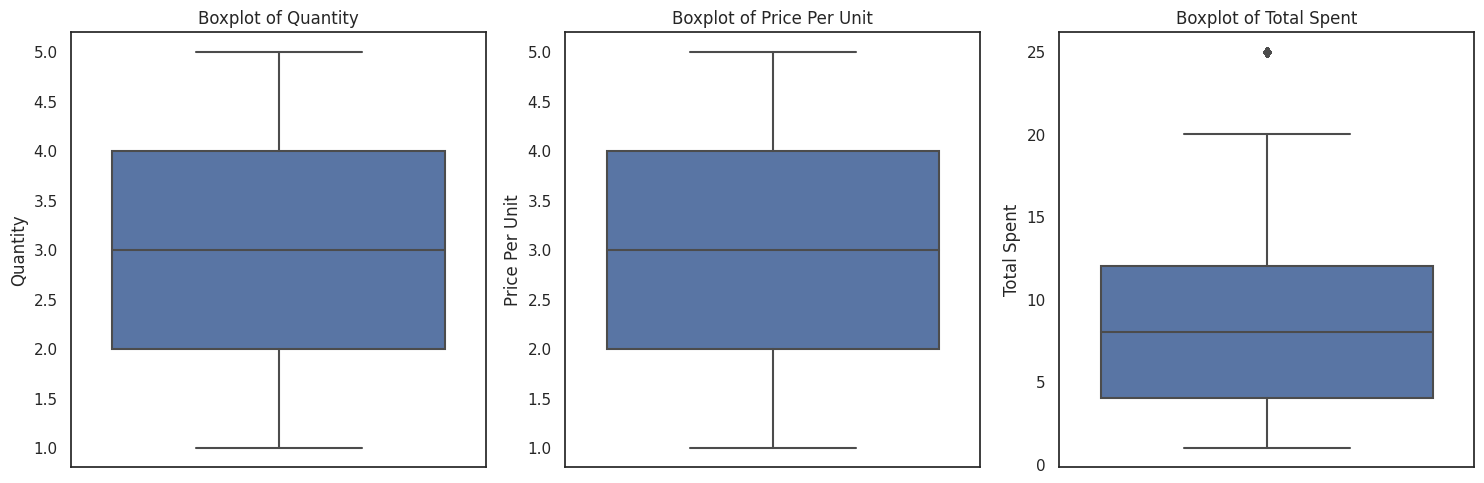

In [25]:
# boxplots of numeric columns

num_cols = ['Quantity', 'Price Per Unit', 'Total Spent']

plt.figure(figsize=(15, 5))
for i, column in enumerate(num_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df1[column])
    plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.show()

Visually, the **Total Spent** column appears to have outliers. We will identify how many outliers exist using the IQR (Interquartile Range) method.

In [26]:
# calculate the quartiles for Total Spent
Q1 = df1['Total Spent'].quantile(0.25)
Q3 = df1['Total Spent'].quantile(0.75)
IQR = Q3 - Q1

# define the bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# calculate the number of outliers
outliers = (df1['Total Spent'] < (lower_bound)) | (df1['Total Spent'] > (upper_bound))
num_outliers = outliers.sum()
print(num_outliers)

268


The IQR method identified 268 outliers in the Total Spent column. However, while these values are technically outliers, they represent genuine entries resulting from the product of Price Per Unit and Quantity. Therefore we will not remove them.